# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [5]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

## Get the data and choose the model

In [6]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact')

In [149]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=10)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

model_RF = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                         RandomForestClassifier(random_state=42, criterion='entropy', max_depth=20, n_estimators=500))

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=500))

In [9]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_SYMBOL', 'VEP_VARIANT_CLASS'],

    'freq': ['frequency_in_normals'],

    'database': ['VEP_COSMIC_CNT', 'VEP_in_dbSNP',
                 'is_a_hotspot', 'is_a_3d_hotspot', 'oncogenic'],

    'consequence': ['gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'Kaviar_AF'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = []
        
    for key, group in features_groups.items():
        if not key in groups_to_remove:
            final_selection += group
    
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove unique values
    return list(set(final_selection))

## Baseline

In [122]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL'])
data.process(features)

X, y = data.get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (194211, 91) | y: (194211,)


,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [123]:
metrics_baseline = Metrics(model_GB, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall', 'precision'])

Run model... done! (366.88s)


In [127]:
metrics_baseline.print_mean()

▴ Mean accuracy         : 0.882 ± 0.004
▴ Mean f1               : 0.331 ± 0.007
▴ Mean roc_auc          : 0.913 ± 0.007
▴ Mean average_precision: 0.606 ± 0.019
▴ Mean recall           : 0.789 ± 0.016
▴ Mean precision        : 0.209 ± 0.005


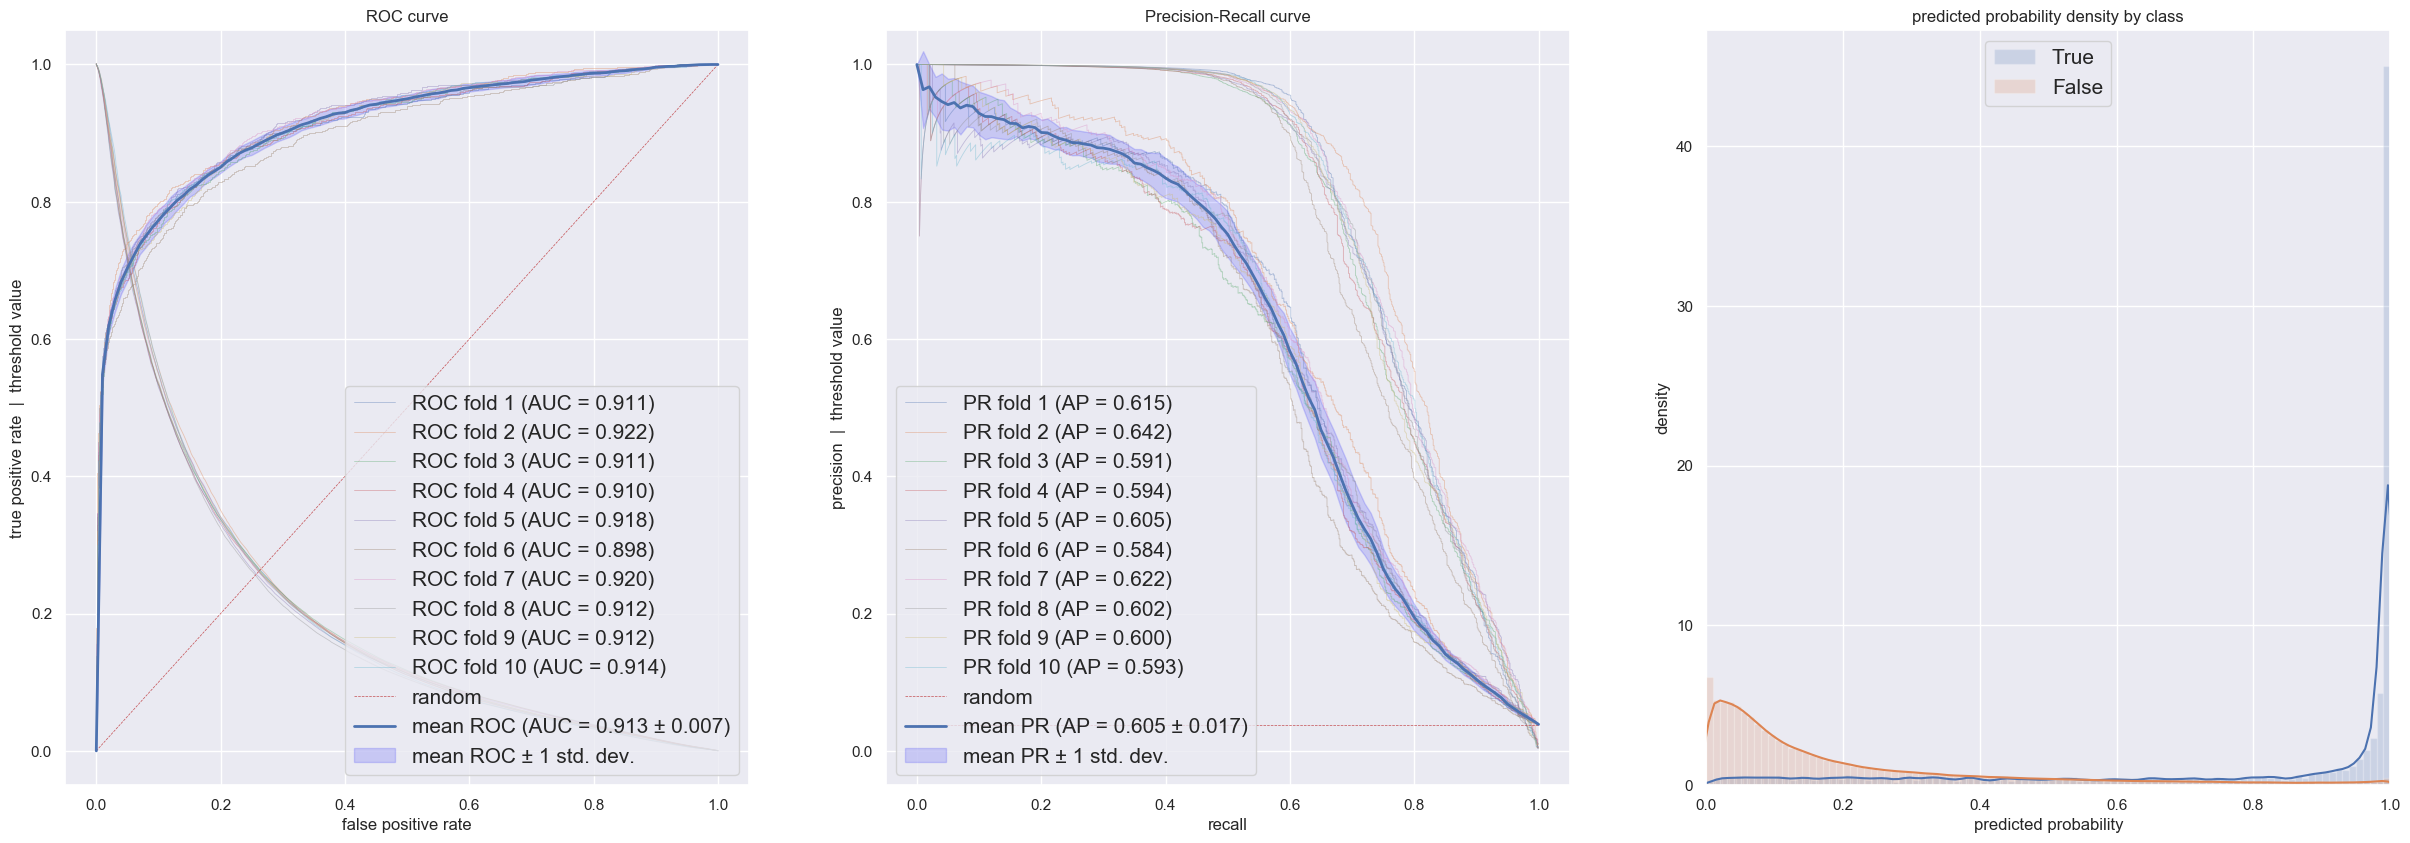

In [14]:
metrics_baseline.plot_threshold_decision_curves()

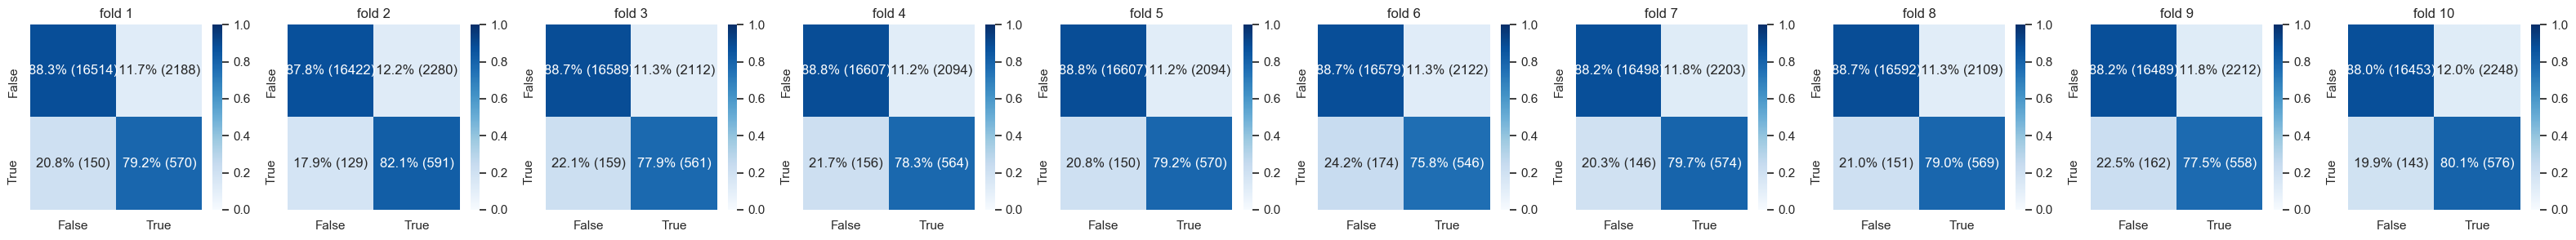

In [15]:
metrics_baseline.plot_confusion_matrix(figsize=(40, 3))

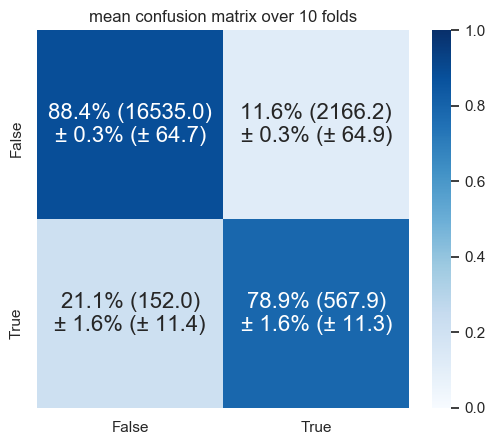

In [16]:
metrics_baseline.plot_mean_confusion_matrix(figsize=(6, 5), legend_size=16)

## Evaluation by groups

In [18]:
metrics_list = {}

for group in features_groups.keys():
    print_md('**Withoug *{}* group**'.format(group))
    features = get_features(groups_to_remove = [group], individual_features_to_remove = ['VEP_SYMBOL'])
    
    print('Get X and y...', end= '')
    start = time.time()
    data.process(features)
    X, y = data.get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} raw features, {} features after processing)'.format(time.time() - start, len(features), X.shape[1]))
    
    metrics_list['without {}'.format(group)] = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall', 'precision'])

**Withoug *NGS* group**

Get X and y... done! (9.62s, 25 raw features, 80 features after processing)
Run model... done! (221.02s)


**Withoug *genome* group**

Get X and y... done! (7.64s, 34 raw features, 63 features after processing)
Run model... done! (202.66s)


**Withoug *freq* group**

Get X and y... done! (8.88s, 35 raw features, 90 features after processing)
Run model... done! (292.64s)


**Withoug *database* group**

Get X and y... done! (6.59s, 31 raw features, 78 features after processing)
Run model... done! (259.74s)


**Withoug *consequence* group**

Get X and y... done! (4.88s, 30 raw features, 64 features after processing)
Run model... done! (229.34s)


**Withoug *AF* group**

Get X and y... done! (10.48s, 25 raw features, 80 features after processing)
Run model... done! (272.52s)


In [113]:
summary = Summary(scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc', 'average_precision'])

for key, color in zip(metrics_list, ['maroon', 'firebrick', 'crimson', 'tomato', 'coral', 'lightcoral']):
    summary.add(metrics_list[key], key, color)

summary.add(metrics_baseline, 'baseline', 'indigo')

,test_accuracy_mean,test_f1_mean,test_recall_mean,test_precision_mean,test_roc_auc_mean,test_average_precision_mean
metrics_name,,,,,,
without NGS,0.855,0.273,0.734,0.167,0.877,0.53
without genome,0.879,0.321,0.769,0.203,0.9,0.596
without freq,0.875,0.318,0.785,0.199,0.907,0.592
without database,0.882,0.33,0.782,0.21,0.908,0.6
without consequence,0.881,0.326,0.775,0.206,0.902,0.596
without AF,0.867,0.307,0.791,0.19,0.906,0.549
all,0.881,0.329,0.789,0.208,0.913,0.605


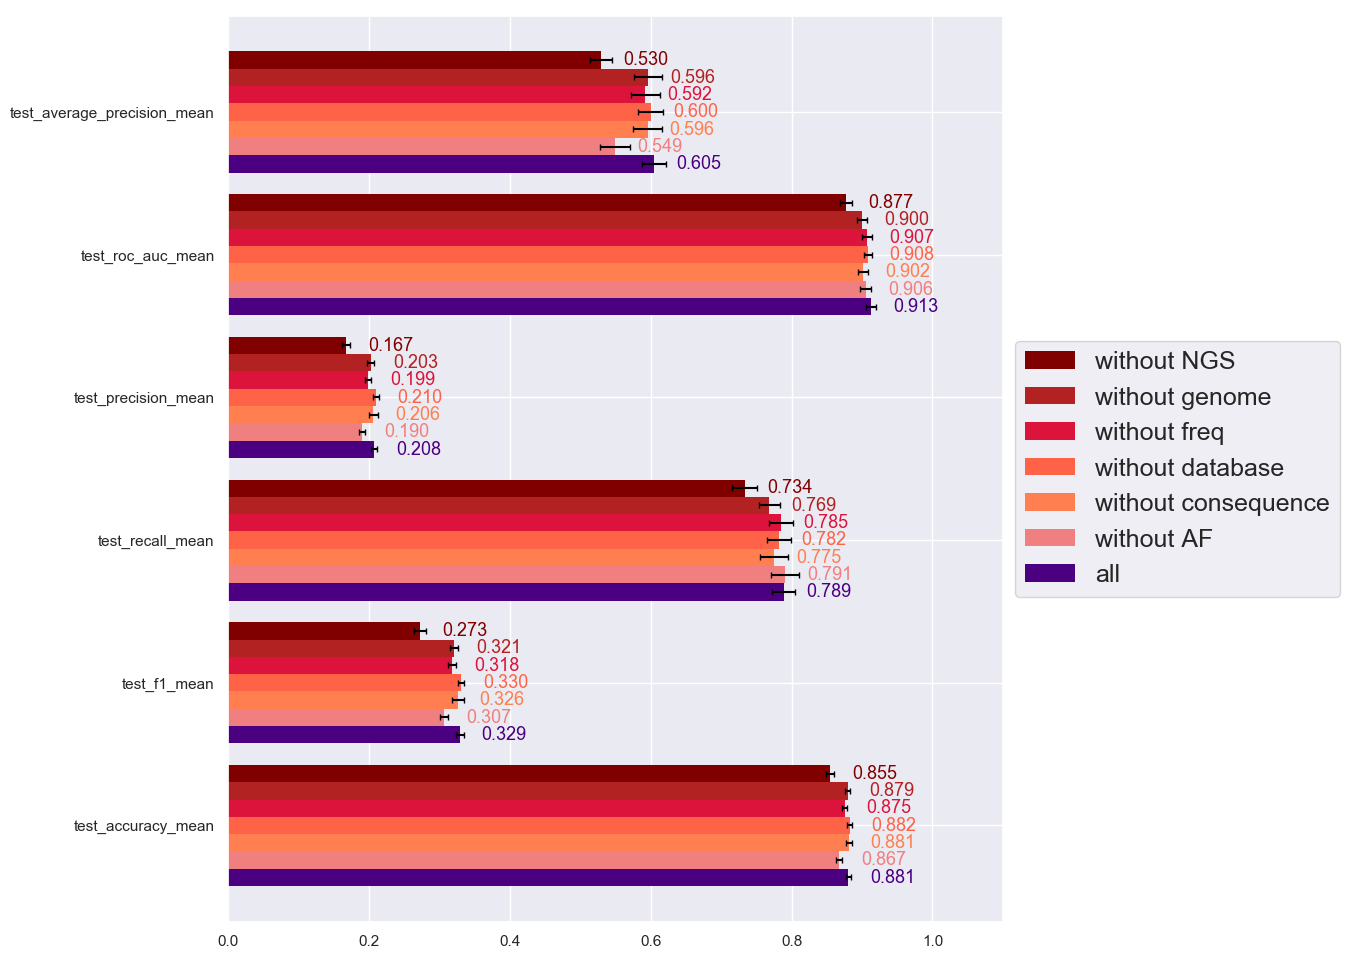

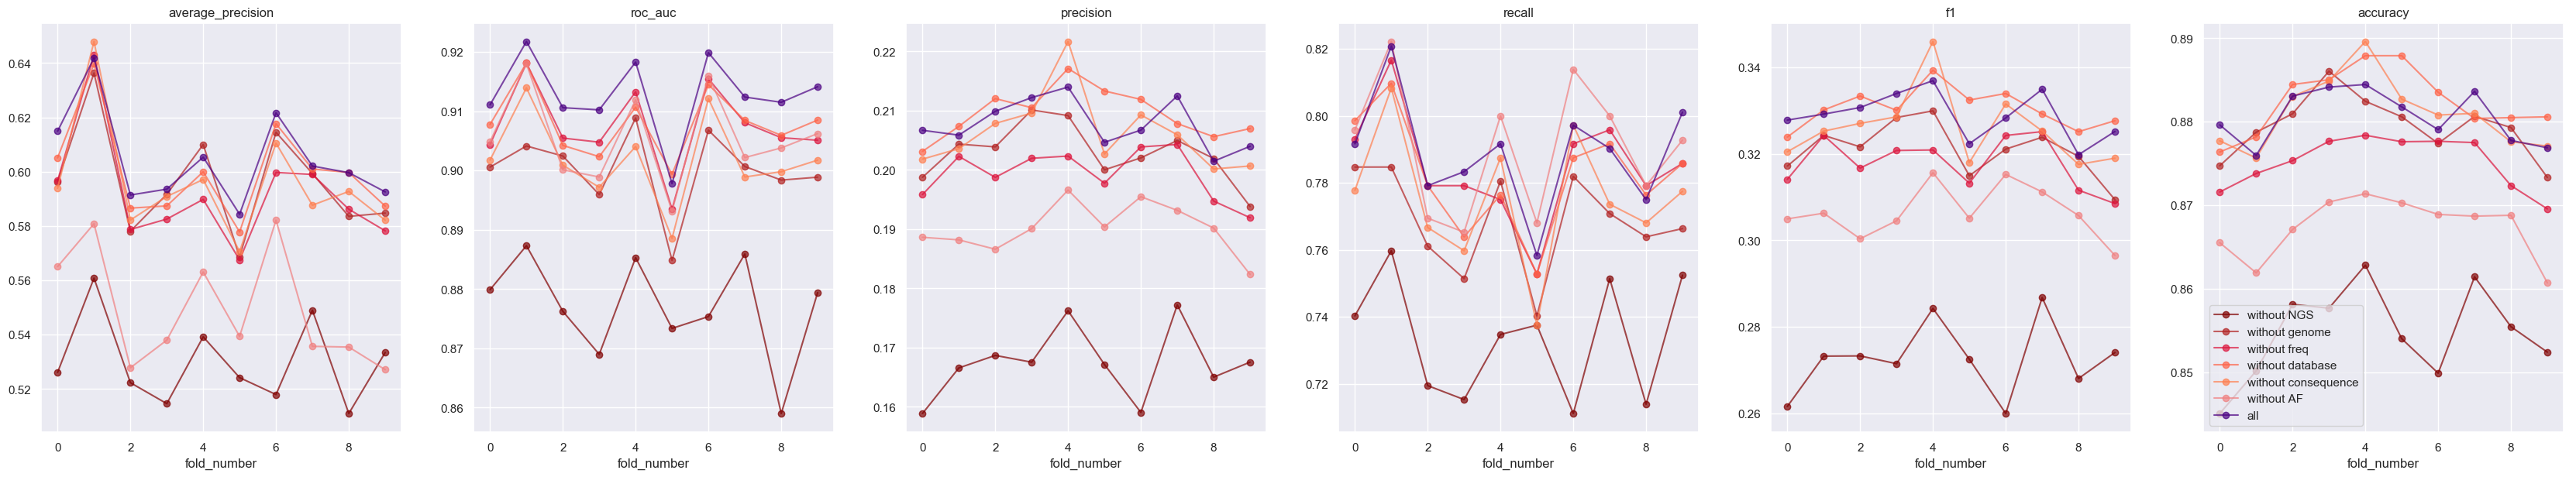

In [115]:
summary.display()
summary.plot()
summary.plot_cv_curves()

## Evaluation with only one group

In [116]:
metrics_list = {}

for group in features_groups.keys():
    print_md('**Only *{}* group**'.format(group))
    features = get_features(groups_to_remove = [g for g in features_groups.keys() if g != group], individual_features_to_remove = ['VEP_SYMBOL'])
    
    print('Get X and y...', end= '')
    start = time.time()
    data.process(features)
    X, y = data.get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} raw features, {} features after processing)'.format(time.time() - start, len(features), X.shape[1]))
    
    metrics_list['only {}'.format(group)] = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall', 'precision'])

**Only *NGS* group**

Get X and y... done! (0.45s, 11 raw features, 11 features after processing)
Run model... done! (69.99s)


**Only *genome* group**

Get X and y... done! (1.82s, 2 raw features, 28 features after processing)
Run model... done! (96.04s)


**Only *freq* group**

Get X and y... done! (0.38s, 1 raw features, 1 features after processing)
Run model... done! (34.88s)


**Only *database* group**

Get X and y... done! (3.84s, 5 raw features, 13 features after processing)
Run model... done! (77.80s)


**Only *consequence* group**

Get X and y... done! (5.48s, 6 raw features, 27 features after processing)
Run model... done! (130.61s)


**Only *AF* group**

Get X and y... done! (0.72s, 11 raw features, 11 features after processing)
Run model... done! (104.60s)


In [119]:
summary_2 = Summary(scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc', 'average_precision'])

for key, color in zip(metrics_list, ['maroon', 'firebrick', 'crimson', 'tomato', 'coral', 'lightcoral']):
    summary_2.add(metrics_list[key], key, color)

summary_2.add(metrics_baseline, 'baseline', 'indigo')

,test_accuracy_mean,test_f1_mean,test_recall_mean,test_precision_mean,test_roc_auc_mean,test_average_precision_mean
metrics_name,,,,,,
only NGS,0.807,0.21,0.693,0.124,0.818,0.347
only genome,0.729,0.121,0.5,0.0686,0.66,0.0783
only freq,0.962,0.329,0.252,0.473,0.622,0.222
only database,0.826,0.197,0.575,0.119,0.753,0.126
only consequence,0.743,0.154,0.629,0.0882,0.763,0.184
only AF,0.935,0.384,0.546,0.296,0.776,0.427
all,0.881,0.329,0.789,0.208,0.913,0.605


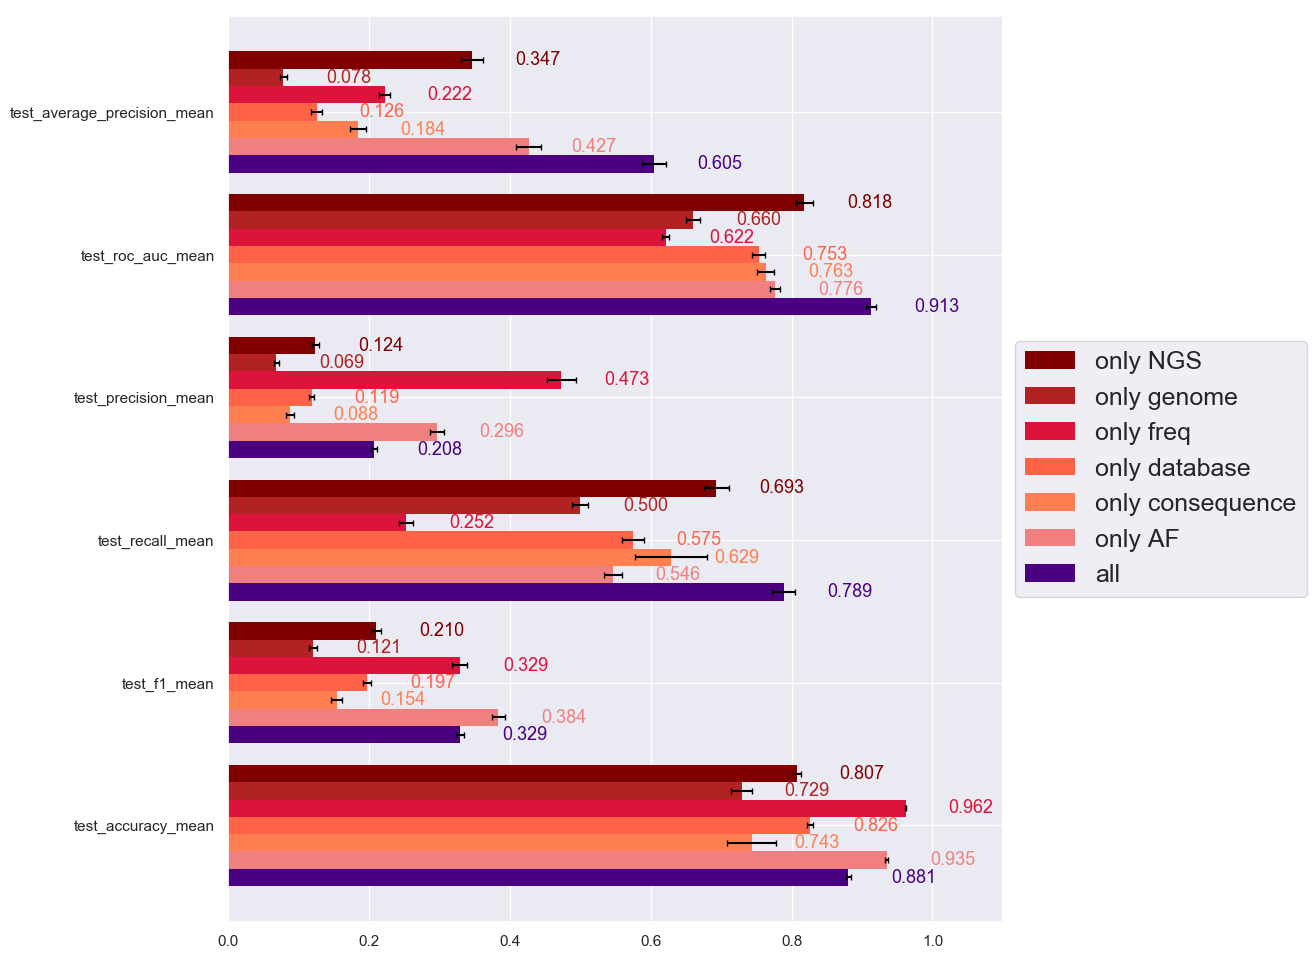

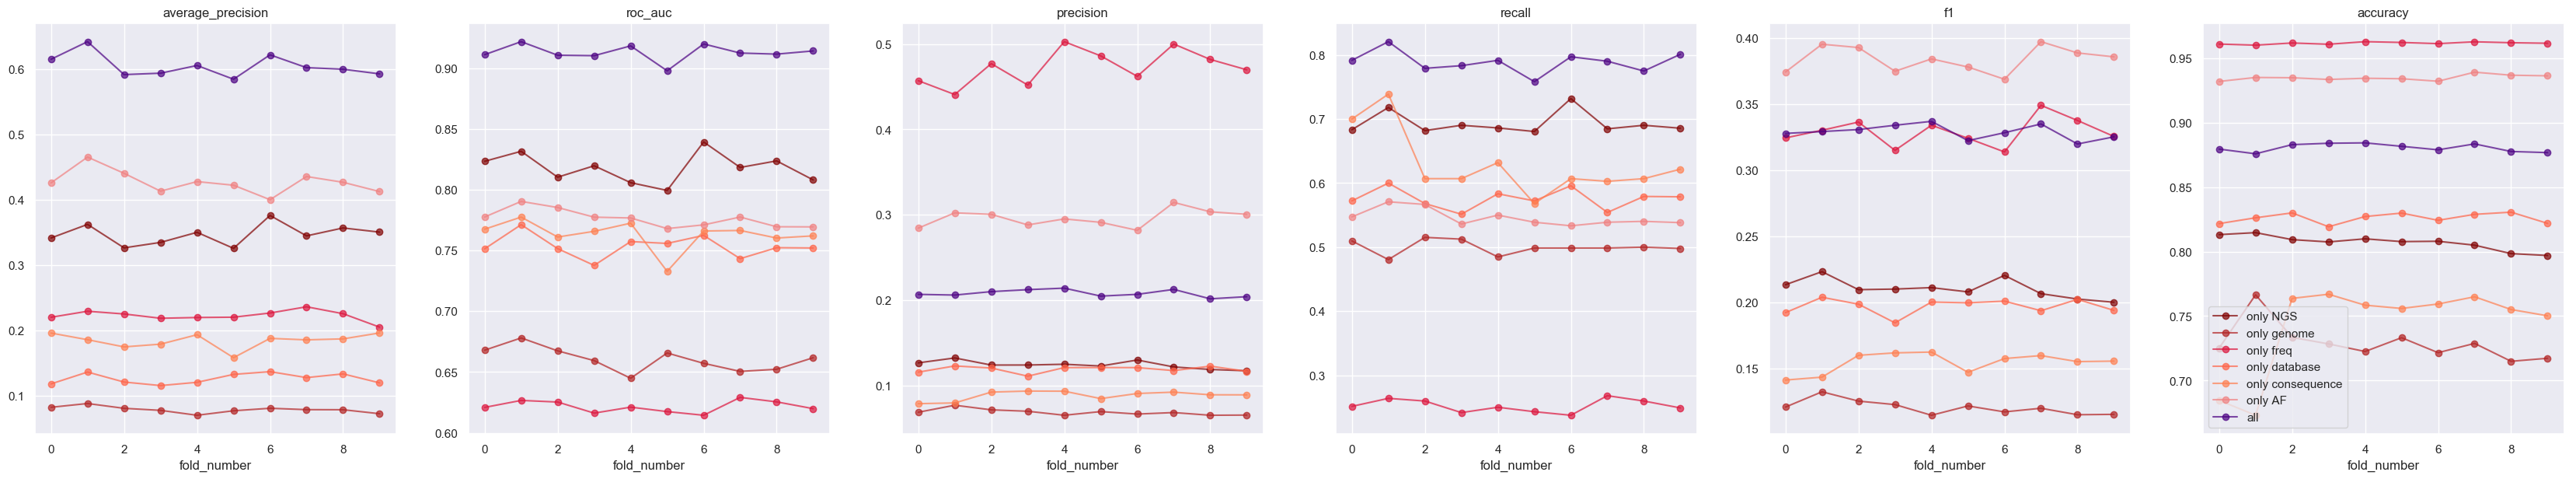

In [120]:
summary_2.display()
summary_2.plot()
summary_2.plot_cv_curves()

## Without gnomAD populations

In [143]:
summary_3 = Summary()
summary_3.add(metrics_baseline, 'baseline', 'indigo')

In [133]:
features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

Run model... done! (318.80s)


In [144]:
summary_3.add(metrics, 'without gnomAD populations', 'firebrick')

,test_accuracy_mean,test_f1_mean,test_recall_mean,test_precision_mean,test_roc_auc_mean,test_average_precision_mean
metrics_name,,,,,,
baseline,0.882,0.331,0.789,0.209,0.913,0.606
without gnomAD populations,0.881,0.329,0.789,0.208,0.913,0.605


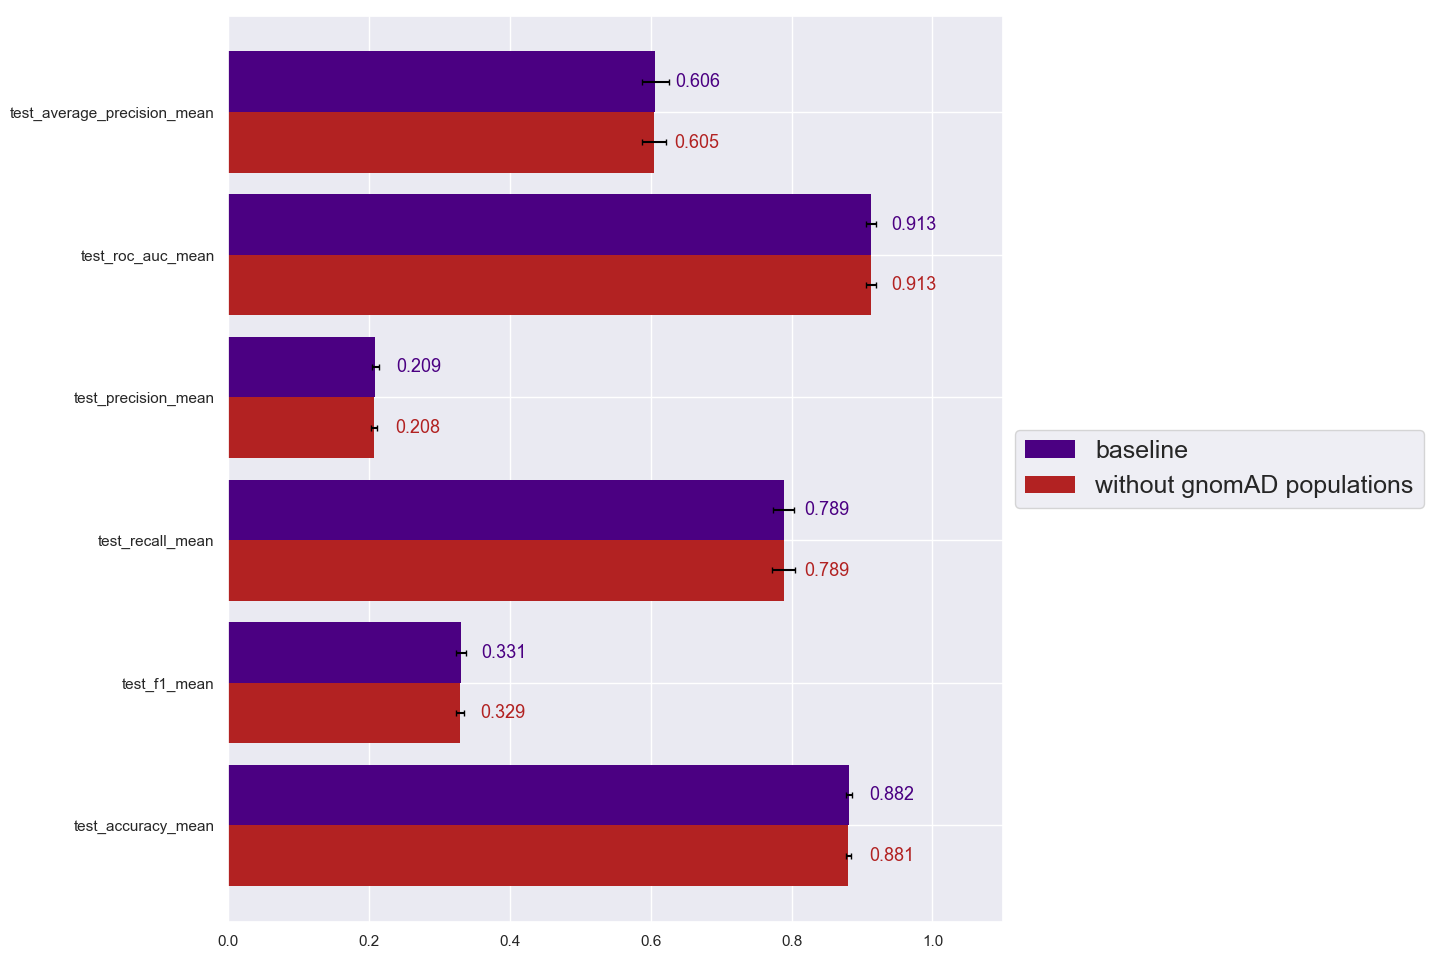

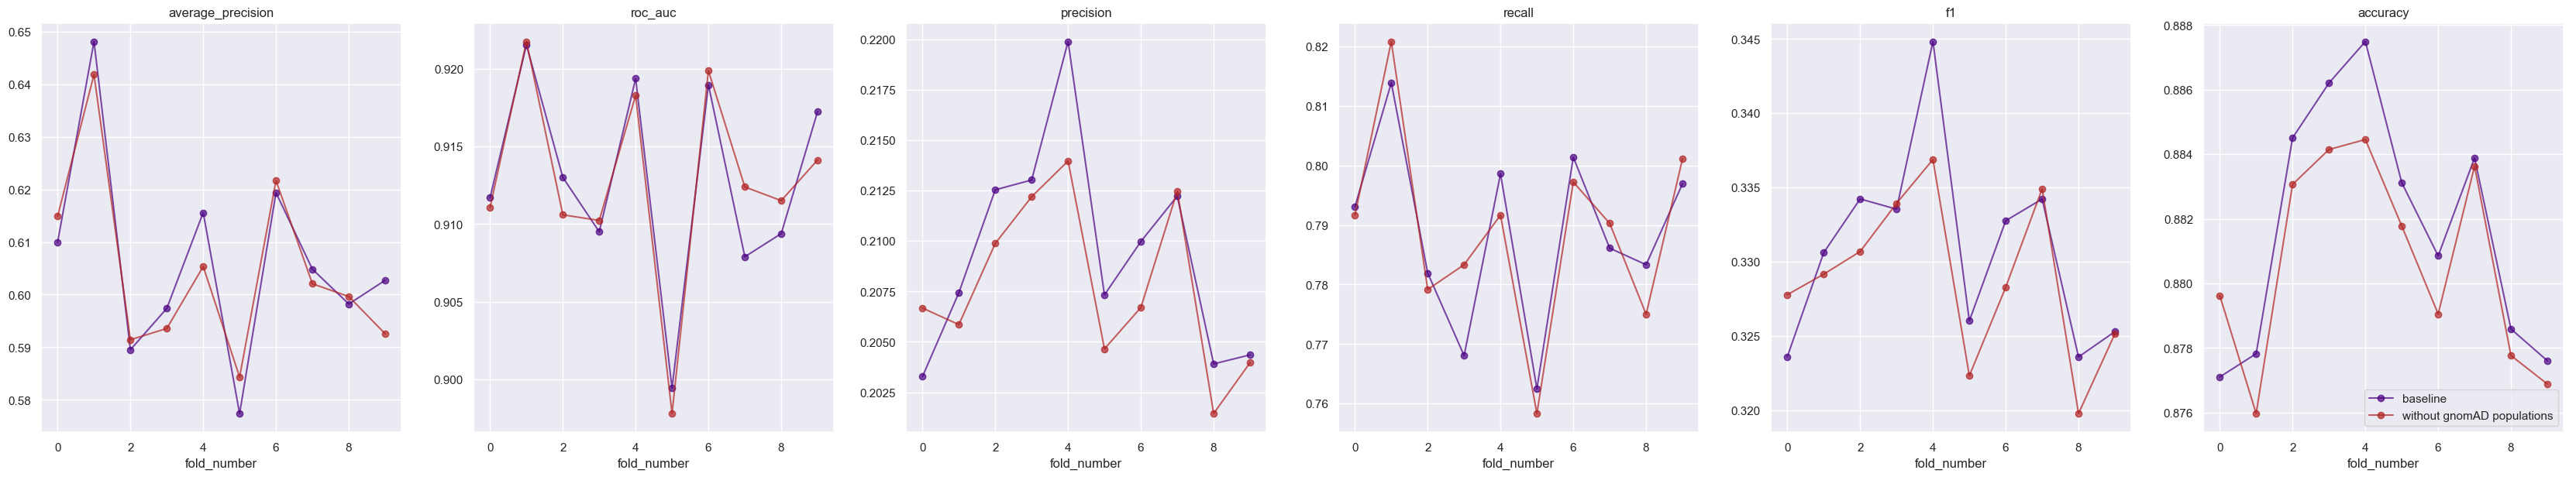

In [145]:
summary_3.display()
summary_3.plot()
summary_3.plot_cv_curves()

In [143]:
summary_4 = Summary()
summary_4.add(metrics_baseline, 'baseline', 'indigo')

In [ ]:
features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

metrics = Metrics(model_RF, X, y, cv_strategy, n_jobs=5)

Run model...

In [144]:
summary_4.add(metrics, 'without gnomAD populations', 'firebrick')

,test_accuracy_mean,test_f1_mean,test_recall_mean,test_precision_mean,test_roc_auc_mean,test_average_precision_mean
metrics_name,,,,,,
baseline,0.882,0.331,0.789,0.209,0.913,0.606
without gnomAD populations,0.881,0.329,0.789,0.208,0.913,0.605


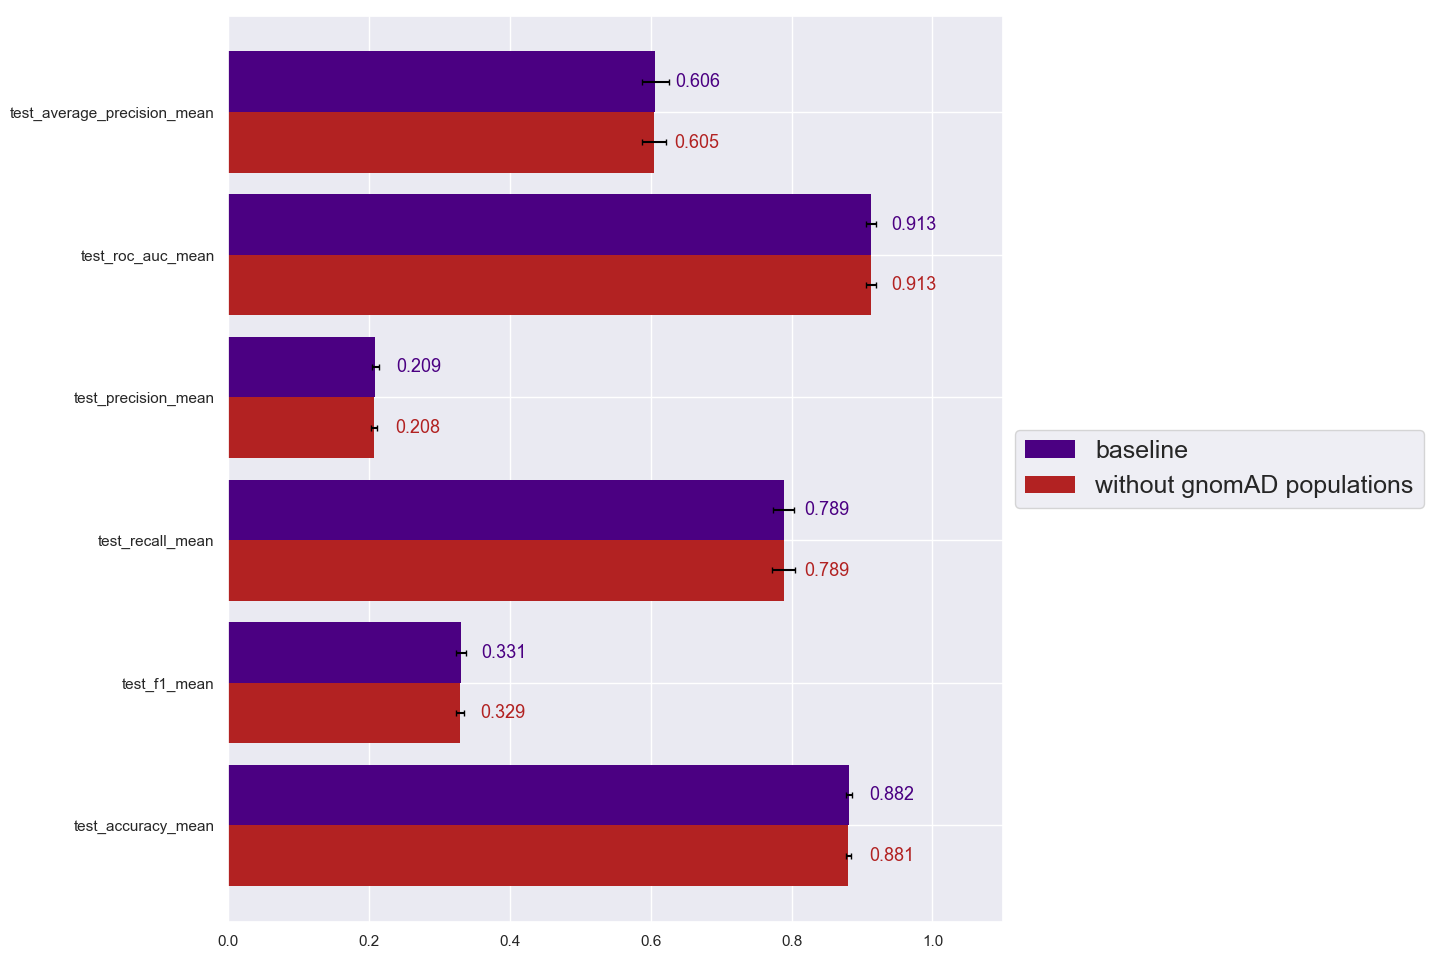

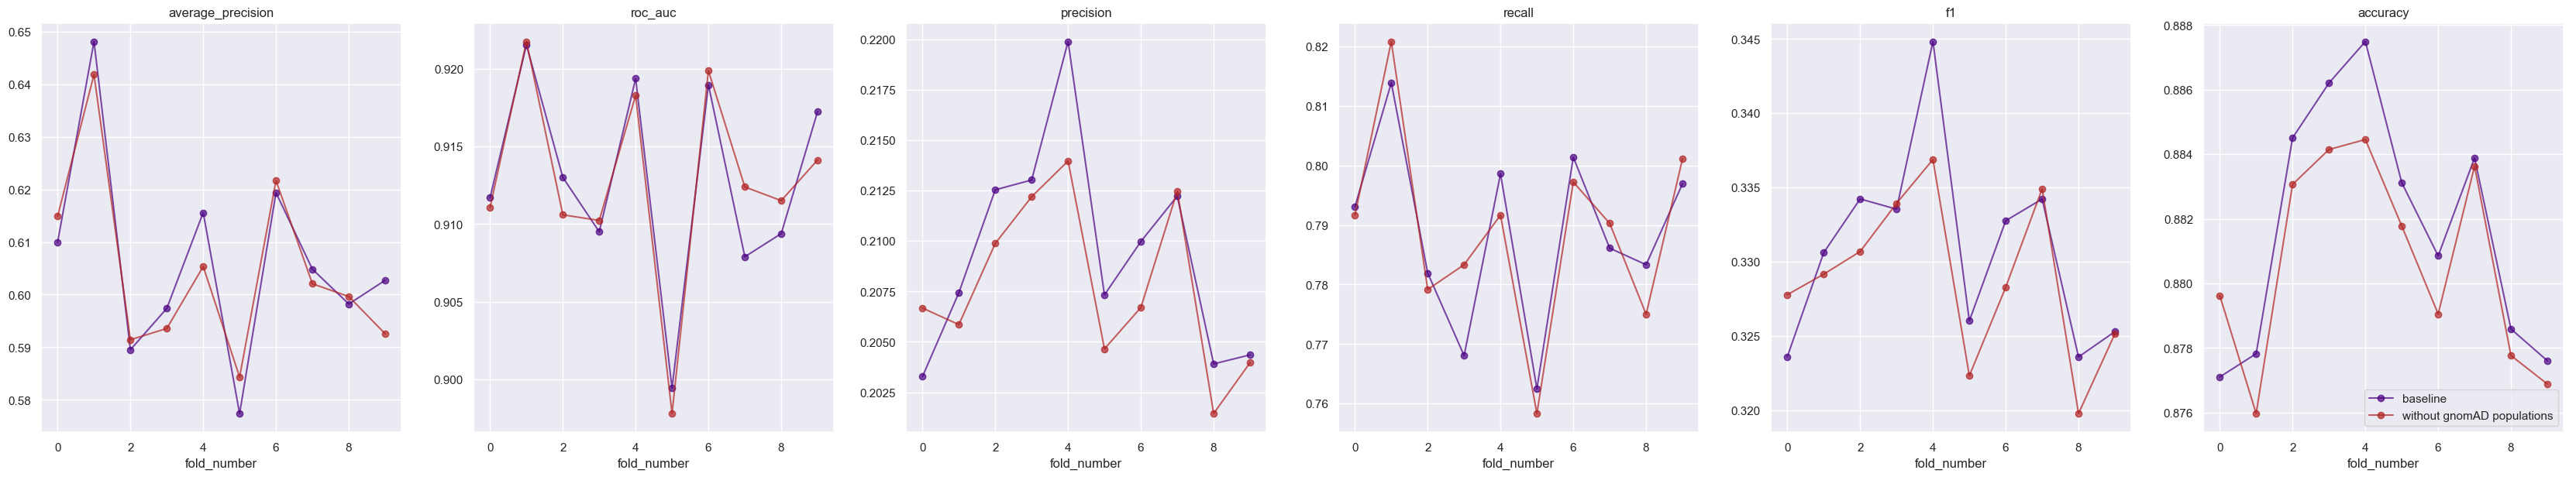

In [145]:
summary_4.display()
summary_4.plot()
summary_4.plot_cv_curves()

## New features tried

In [11]:
summary_4 = Summary()
summary_4.add(metrics_baseline, 'baseline', 'indigo')